# Q0 Explore the data

## Q0.0 Load Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = './ad_click_dataset.csv'
df = pd.read_csv(file_path)

In [24]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)



## Q0.1 Explore the data

In [25]:

# 1. Initial Data Overview
print("Dataset Shape:", df.shape)
print("\nData Info:")
df.info()

# 2. Check for Duplicates
print("\n=== Duplicate Analysis ===")
# Check for exact duplicates
exact_duplicates = df.duplicated().sum()
print(f"Exact duplicates: {exact_duplicates}")

# Check for potential duplicates based on all columns except 'id'
potential_duplicates = df.drop('id', axis=1).duplicated().sum()
print(f"Potential duplicates (excluding id): {potential_duplicates}")

# Check for duplicate ids
duplicate_ids = df['id'].duplicated().sum()
print(f"Duplicate IDs: {duplicate_ids}")

# 3. Missing Values Analysis
print("\n=== Missing Values Analysis ===")
missing_analysis = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_analysis)

# 4. Data Validation
print("\n=== Data Validation ===")
# Check click values
print("\nClick value distribution:")
print(df['click'].value_counts(dropna=False))

# Check ad positions
print("\nAd position distribution:")
print(df['ad_position'].value_counts(dropna=False))



Dataset Shape: (10000, 9)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB

=== Duplicate Analysis ===
Exact duplicates: 2853
Potential duplicates (excluding id): 2853
Duplicate IDs: 6000

=== Missing Values Analysis ===
                  Missing Count  Missing Percentage
id                            0               0.000
full_name               

In [26]:
def explore_dataset(df, title="Dataset Analysis"):
    """
    Performs comprehensive analysis of a dataset including duplicates, missing values, and data validation.
    
    Args:
        df (pandas.DataFrame): The dataframe to analyze
        title (str): Title for the analysis output
    """
    print(f"\n{'='*20} {title} {'='*20}")
    
    # 1. Initial Data Overview
    print("\nDataset Shape:", df.shape)
    print("\nData Info:")
    df.info()

    # 2. Check for Duplicates
    print("\n=== Duplicate Analysis ===")
    exact_duplicates = df.duplicated().sum()
    potential_duplicates = df.drop('id', axis=1).duplicated().sum()
    duplicate_ids = df['id'].duplicated().sum()
    
    print(f"Exact duplicates: {exact_duplicates}")
    print(f"Potential duplicates (excluding id): {potential_duplicates}")
    print(f"Duplicate IDs: {duplicate_ids}")

    # 3. Missing Values Analysis
    print("\n=== Missing Values Analysis ===")
    missing_analysis = pd.DataFrame({
        'Missing Count': df.isnull().sum(),
        'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    print(missing_analysis)

    # 4. Data Validation
    print("\n=== Data Validation ===")
    print("\nClick value distribution:")
    print(df['click'].value_counts(dropna=False))
    
    print("\nAd position distribution:")
    print(df['ad_position'].value_counts(dropna=False))

# 사용 예시:
# analyze_dataset(df, "Original Dataset")
# analyze_dataset(df_clean, "Cleaned Dataset")

In [27]:
explore_dataset(df, "Original Dataset")


==================== Original Dataset ====================

Dataset Shape: (10000, 9)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB

=== Duplicate Analysis ===
Exact duplicates: 2853
Potential duplicates (excluding id): 2853
Duplicate IDs: 6000

=== Missing Values Analysis ===
                  Missing Count  Missing Percentage
id             

## Q0.2 Clean Data

In [28]:


# 9. Recommendations for Clean CTR Analysis
def get_clean_data_for_ctr():
    """
    Returns a cleaned dataset for CTR analysis based on quality criteria
    """
    df_clean = df.copy()
    
    df_clean = df_clean.drop_duplicates()
    
    return df_clean

df_clean = get_clean_data_for_ctr()

# Save the clean dataset
clean_filename = 'ad_click_dataset_clean.csv'
df_clean.to_csv(clean_filename, index=False)
print(f"Cleaned data saved under: '{clean_filename}'")
print(f"- Original row count: {len(df):,}")
print(f"- Cleaned row count: {len(df_clean):,}")

Cleaned data saved under: 'ad_click_dataset_clean.csv'
- Original row count: 10,000
- Cleaned row count: 7,147


In [29]:
explore_dataset(df_clean, "Cleaned Dataset")


==================== Cleaned Dataset ====================

Dataset Shape: (7147, 9)

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7147 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7147 non-null   int64  
 1   full_name         7147 non-null   object 
 2   age               3671 non-null   float64
 3   gender            3747 non-null   object 
 4   device_type       5419 non-null   object 
 5   ad_position       5404 non-null   object 
 6   browsing_history  3667 non-null   object 
 7   time_of_day       5435 non-null   object 
 8   click             7147 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 558.4+ KB

=== Duplicate Analysis ===
Exact duplicates: 0
Potential duplicates (excluding id): 0
Duplicate IDs: 3147

=== Missing Values Analysis ===
                  Missing Count  Missing Percentage
id                           

In [30]:
# Create Data Quality Score
print("\n=== Data Quality Score ===")
df_clean['data_quality_score'] = df_clean.apply(lambda x: sum([
    not pd.isnull(x['age']),
    not pd.isnull(x['gender']),
    not pd.isnull(x['device_type']),
    not pd.isnull(x['ad_position']),
    not pd.isnull(x['browsing_history']),
    not pd.isnull(x['time_of_day'])
]), axis=1)

print("\nData quality score distribution:")
print(df_clean['data_quality_score'].value_counts(normalize=True).sort_index() * 100)

df_clean.to_csv('ad_click_clean_dataset_quality.csv', index=False)


=== Data Quality Score ===

Data quality score distribution:
data_quality_score
0    0.098
1    1.805
2   10.298
3   25.577
4   33.818
5   22.247
6    6.156
Name: proportion, dtype: float64


## Q0.3 Make Observations

Of the original dataset, 2853 rows are duplicates and were removed.
There are missing values but they are in clusters
  - 0% missing: id, full_name, click; these form the core fact table metrics
  - ~25% missing: device_type, ad_position, time_of_day. These are key categorization dimensions
  - ~50% missing: age, gender, browsing_history. Age, gender are demographic attributes which are slowly changing dimensions.

In [31]:
df_quality = pd.read_csv('ad_click_clean_dataset_quality.csv')
df_quality

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,data_quality_score
0,670,User670,22.000,NaN,Desktop,Top,Shopping,Afternoon,1,5
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1,3
2,5912,User5912,41.000,Non-Binary,NaN,Side,Education,Night,1,5
3,5418,User5418,34.000,Male,NaN,NaN,Entertainment,Evening,1,4
4,9452,User9452,39.000,Non-Binary,NaN,NaN,Social Media,Morning,0,4
...,...,...,...,...,...,...,...,...,...,...
7142,8510,User8510,NaN,NaN,Mobile,Top,Education,NaN,0,3
7143,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0,4
7144,3914,User3914,NaN,Male,Mobile,Side,NaN,Morning,0,4
7145,7924,User7924,NaN,NaN,Desktop,NaN,Shopping,Morning,1,3



=== CTR Analysis by Data Completeness ===

CTR Analysis for position:
             click          CTR
             count   sum       
has_position                   
False         1743  1025 58.810
True          5404  2622 48.520

CTR Analysis for device:
           click          CTR
           count   sum       
has_device                   
False       1728  1038 60.070
True        5419  2609 48.150

CTR Analysis for time:
         click          CTR
         count   sum       
has_time                   
False     1712   996 58.180
True      5435  2651 48.780

CTR Analysis for age:
        click          CTR
        count   sum       
has_age                   
False    3476  1859 53.480
True     3671  1788 48.710

CTR Analysis for gender:
           click          CTR
           count   sum       
has_gender                   
False       3400  1758 51.710
True        3747  1889 50.410

CTR Analysis for history:
            click          CTR
            count   sum       
has_hi

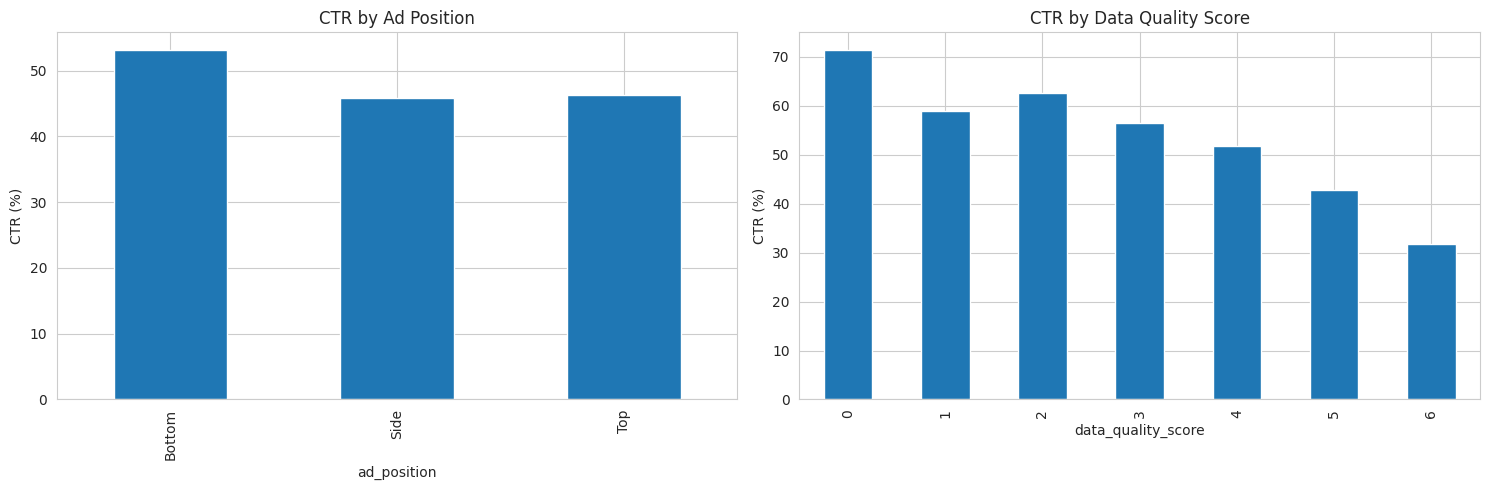

In [32]:

# CTR Analysis by Missing Data
def calculate_ctr(group):
    return (group['click'].sum() / len(group) * 100).round(2)

print("\n=== CTR Analysis by Data Completeness ===")

# Create binary columns for presence of each feature
df_quality['has_position'] = ~df_quality['ad_position'].isna()
df_quality['has_device'] = ~df_quality['device_type'].isna()
df_quality['has_time'] = ~df_quality['time_of_day'].isna()
df_quality['has_age'] = ~df_quality['age'].isna()
df_quality['has_gender'] = ~df_quality['gender'].isna()
df_quality['has_history'] = ~df_quality['browsing_history'].isna()

# Analyze CTR for each feature's presence/absence
for column in ['has_position', 'has_device', 'has_time', 'has_age', 'has_gender', 'has_history']:
    feature_name = column.replace('has_', '')
    print(f"\nCTR Analysis for {feature_name}:")
    ctr_analysis = df_quality.groupby(column).agg({
        'click': ['count', 'sum']
    }).assign(CTR=lambda x: (x['click']['sum'] / x['click']['count'] * 100).round(2))
    
    print(ctr_analysis)


# CTR by Data Quality
print("\n=== CTR by Data Quality Score ===")
ctr_by_quality = df_quality.groupby('data_quality_score')['click'].agg(['count', 'sum']).assign(
    CTR=lambda x: (x['sum'] / x['count'] * 100).round(2)
)
print(ctr_by_quality)

# Visualization of Key Metrics
plt.figure(figsize=(15, 5))


# CTR by Ad Position
plt.subplot(1, 2, 1)
ctr_by_pos = df_quality.groupby('ad_position')['click'].mean() * 100
ctr_by_pos.plot(kind='bar')
plt.title('CTR by Ad Position')
plt.ylabel('CTR (%)')

# PCTR by Data Quality Score
plt.subplot(1, 2, 2)
ctr_by_quality['CTR'].plot(kind='bar')
plt.title('CTR by Data Quality Score')
plt.ylabel('CTR (%)')

plt.tight_layout()
plt.show()

This indicates that the rows with missing values are performing better than the with information. There is a possibility of potential bias. This indicates one's data acquisition may need to be looked into. 

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Read the data
df = pd.read_csv('ad_click_dataset_clean.csv')

# 1. Create Missing Value Analysis Function
def analyze_missing_patterns(df, feature, target='ad_position'):
    """
    Analyze the relationship between missing values in target column 
    and distribution of another feature
    """
    # Create contingency table
    missing_vs_feature = pd.crosstab(
        df[target].isnull(),
        df[feature],
        normalize='index'
    )
    
    # Chi-square test
    obs = pd.crosstab(df[target].isnull(), df[feature])
    chi2, p_value = stats.chi2_contingency(obs)[:2]
    
    return missing_vs_feature, chi2, p_value

# 2. Analyze Missing Patterns
print("=== Missing Value Pattern Analysis ===")

features_to_analyze = ['device_type', 'time_of_day', 'gender']
missing_patterns = {}

for feature in features_to_analyze:
    dist, chi2, p_value = analyze_missing_patterns(df, feature)
    missing_patterns[feature] = {
        'distribution': dist,
        'chi2': chi2,
        'p_value': p_value
    }
    print(f"\nMissing Pattern Analysis for {feature}")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")
    print("\nDistribution:")
    print(dist)


=== Missing Value Pattern Analysis ===

Missing Pattern Analysis for device_type
Chi-square statistic: 0.0014
P-value: 0.9993

Distribution:
device_type  Desktop  Mobile  Tablet
ad_position                         
False          0.339   0.335   0.326
True           0.340   0.334   0.326

Missing Pattern Analysis for time_of_day
Chi-square statistic: 9.3747
P-value: 0.0247

Distribution:
time_of_day  Afternoon  Evening  Morning  Night
ad_position                                    
False            0.241    0.248    0.258  0.253
True             0.263    0.232    0.283  0.222

Missing Pattern Analysis for gender
Chi-square statistic: 2.6941
P-value: 0.2600

Distribution:
gender       Female  Male  Non-Binary
ad_position                          
False         0.346 0.335       0.319
True          0.321 0.362       0.318


From this analysis, we can identify several key insights:

- Device Type (p=0.9993):
  There's NO significant relationship between missing ad positions and device type
  Distribution is remarkably consistent:

  - Desktop: ~34% for both missing and non-missing
  - Mobile: ~33.5% for both
  - Tablet: ~32.6% for both

This is good news: device type isn't biasing our missing data

- Time of Day (p=0.0247):
  There IS a significant relationship (p < 0.05)
  Notable differences:

  - Morning: 28.3% vs 25.8% (overrepresented in missing data)
  - Night: 22.2% vs 25.3% (underrepresented in missing data)
  - Evening: 23.2% vs 24.8% (slightly underrepresented)
  - Afternoon: 26.3% vs 24.1% (slightly overrepresented)

This suggests time-of-day bias in our missing data


- Gender (p=0.2600):
  No statistically significant relationship
  But some noticeable patterns:

  - Male: 36.2% vs 33.5% (larger difference)
  - Female: 32.1% vs 34.6% (moderate difference)
  - Non-Binary: ~31.8% (consistent)



# Q1. Is the top ad position the best performing position in terms of CTR?

## Answer

## How-to

There are missing values in ad_position. Let's goahead and see if top ad position is the best performing spot in terms of click-through rate including missing values.

In [6]:
# CTR Analysis without duplicate columns
ctr_by_position = (df_clean
    .groupby('ad_position', dropna=False)  # Keep NaN values
    .agg({
        'click': ['count', 'sum', 'mean']
    })
    .pipe(lambda x: x.set_axis(['Impressions', 'Clicks', 'CTR'], axis=1))
    .assign(
        CTR_pct=lambda x: (x['CTR'] * 100).round(2)
    )
    .assign(
        CTR=lambda x: x['CTR_pct'].astype(str) + '%'
    )
    .drop('CTR_pct', axis=1)
)

print("\nCTR Analysis by Position (including NaN):")
ctr_by_position



CTR Analysis by Position (including NaN):


,Impressions,Clicks,CTR
ad_position,,,
Bottom,1881,1000,53.16%
Side,1758,805,45.79%
Top,1765,817,46.29%
NaN,1743,1025,58.81%


/tmp/ipykernel_48419/2364414562.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


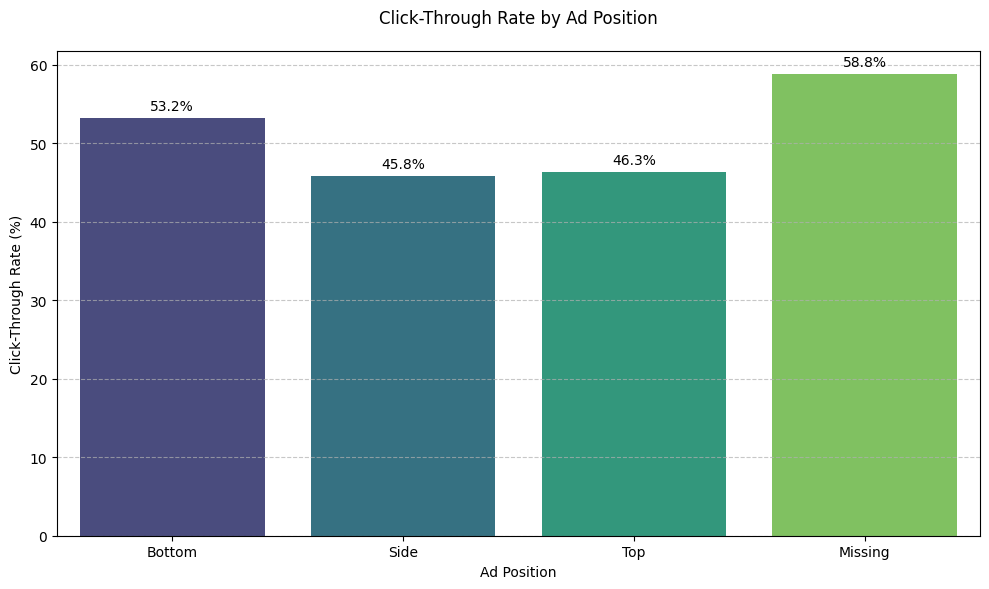

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# This will be included in the google slide

# For plotting, convert the index to string and replace NaN with 'Missing'
plot_data = ctr_by_position.assign(
    CTR_pct=lambda x: x['CTR'].str.rstrip('%').astype(float)
)
plot_data.index = plot_data.index.fillna('Missing')  # Replace NaN with 'Missing' in index


# Create visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=plot_data.index, 
    y='CTR_pct', 
    data=plot_data, 
    palette='viridis'
)

# Add value labels on top of bars
for i, v in enumerate(plot_data['CTR_pct']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center')

# Customize the plot
plt.title('Click-Through Rate by Ad Position', pad=20)
plt.xlabel('Ad Position')
plt.ylabel('Click-Through Rate (%)')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Marketing team's belief that the top ad position performs best in terms of click through rates does not seem to be supported by data including missing values. It is in the order of 'Missing', 'Bottom', 'Top', 'Side'.

Let's determine if I am missing something with rows with missing position by examining if there's pattern. 

From CTR point of view, bottom performs the best but is this statistically significant? 
There are statistical tests applicable: 
  - t-test
  - chi-square test

T-test Requirements:
- Assumes normal distribution
- Continuous data
- Independent observations

Chi-square Test Requirements:
- Categorical data (which we have)
- Independent observations
- No assumption about distribution
- *This* is my choice of test since I want to see if there's a relationship between ad position and click rate. 


In [43]:
from scipy.stats import chi2_contingency

# Create contingency table
contingency = pd.crosstab(df_clean['ad_position'], df_clean['click'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency)

print("Contingency Table:")
print(contingency)
print("\nChi-square test results:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

# If you want to see which positions are significantly different,
# you can run pairwise comparisons
positions = df_clean['ad_position'].unique()
print("\nPairwise comparisons:")
for i in range(len(positions)):
    for j in range(i+1, len(positions)):
        pos1, pos2 = positions[i], positions[j]
        subset = df_clean[df_clean['ad_position'].isin([pos1, pos2])]
        cont_table = pd.crosstab(subset['ad_position'], subset['click'])
        chi2, p_value, _, _ = chi2_contingency(cont_table)
        print(f"{pos1} vs {pos2}:")
        print(f"Chi-square: {chi2:.2f}, p-value: {p_value:.4f}")

Contingency Table:
click          0     1
ad_position           
Bottom       881  1000
Side         953   805
Top          948   817

Chi-square test results:
Chi-square statistic: 25.00
p-value: 0.0000
Degrees of freedom: 2

Pairwise comparisons:
Top vs Side:
Chi-square: 0.07, p-value: 0.7926
Top vs nan:
Chi-square: 0.00, p-value: 1.0000
Top vs Bottom:
Chi-square: 16.94, p-value: 0.0000
Side vs nan:
Chi-square: 0.00, p-value: 1.0000
Side vs Bottom:
Chi-square: 19.46, p-value: 0.0000
nan vs Bottom:
Chi-square: 0.00, p-value: 1.0000


Overall Chi-square Test:
Chi-square statistic: 25.00
p-value: 0.0000 (< 0.05)


This indicates there is a statistically significant relationship between ad position and click rates. 

In other words, ad position does affect CTR Bottom position performs significantly better than both Top and Side. There's no significant difference between Top and Side positions. The marketing team's belief about Top position performing best is incorrect 

Top vs Side:     p-value: 0.7926 (not significant)
Top vs Bottom:   p-value: 0.0000 (significant)
Side vs Bottom:  p-value: 0.0000 (significant)

So not only are we refuting the null hypothesis that all positions perform the same, but we can specifically say: Bottom performs differently (better) than both Top and Side
Top and Side perform similarly to each other

This is contrary to marketing wisdom that a person's vision of scope is highest at the top of the page and diminishes as we go down like the letter 'F' and begs the question why the bottom is the best which ties with the data quality score analysis that missing values are performing better. 

# Q2 Demonstrate the difference in the time of day vs. viewer age distribution 

Use a statistical test and a visualisation that illustrates the difference in the “time of day” variable and the age distribution of participants who see our ads.


## Answer

## How-to

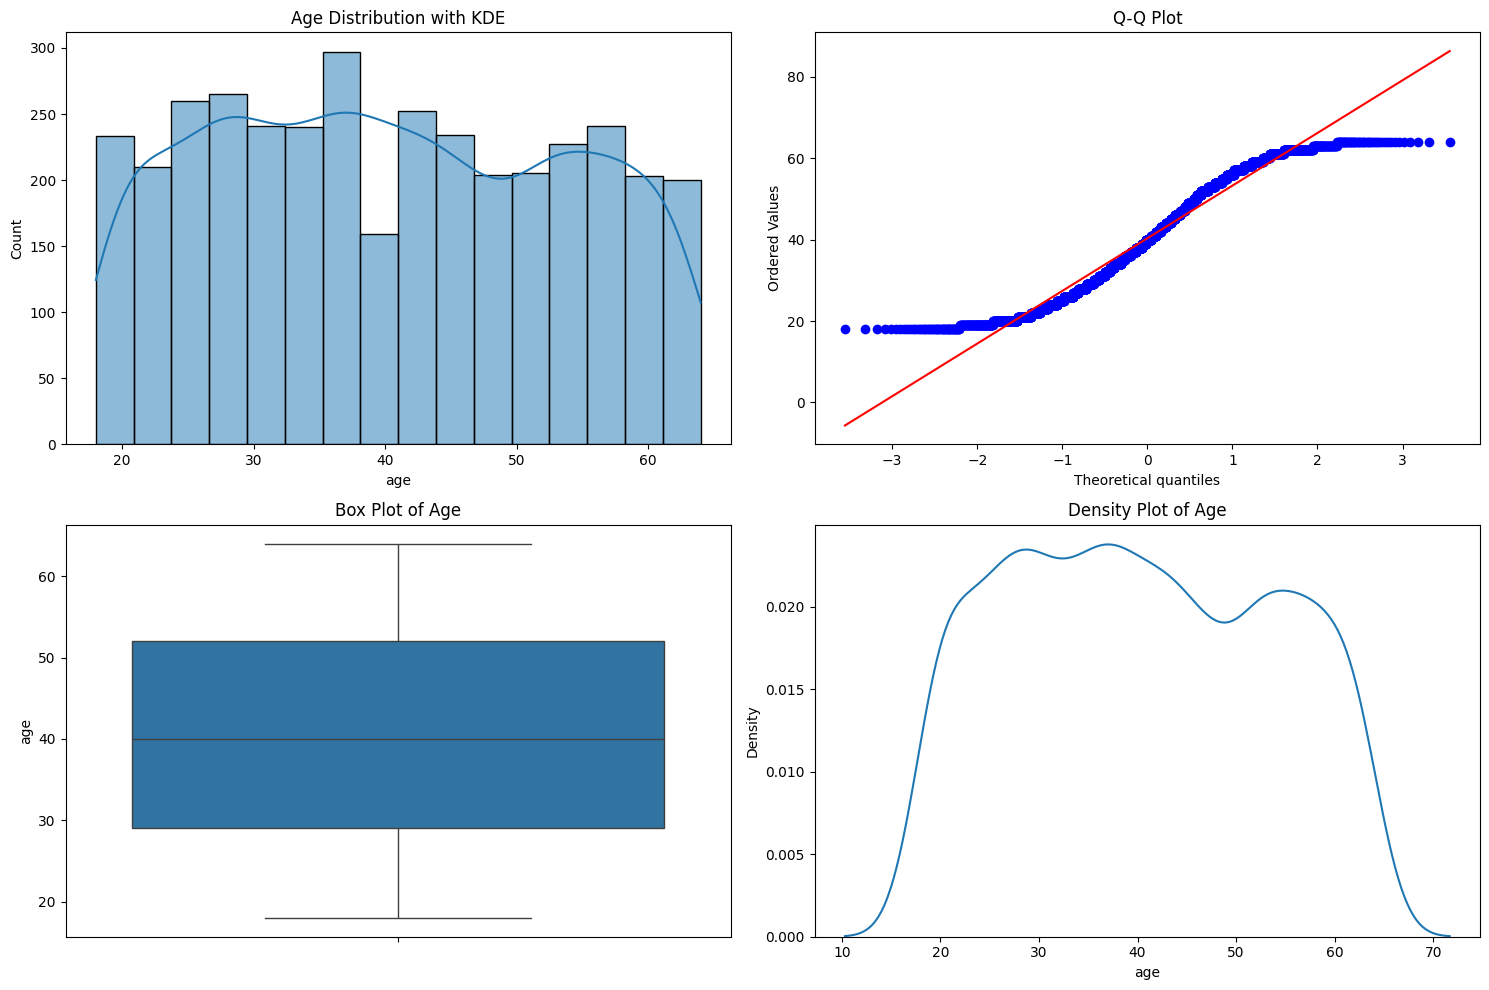

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

df = pd.read_csv('ad_click_clean_dataset_quality.csv')

# Create figure with multiple plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram with KDE
sns.histplot(data=df, x='age', kde=True, ax=ax1)
ax1.set_title('Age Distribution with KDE')

# 2. Q-Q plot
stats.probplot(df['age'].dropna(), dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot')

# 3. Box plot
sns.boxplot(y=df['age'], ax=ax3)
ax3.set_title('Box Plot of Age')

# 4. Density plot
sns.kdeplot(data=df, x='age', ax=ax4)
ax4.set_title('Density Plot of Age')

plt.tight_layout()
plt.show()


Given the non-normality of age distribution:
  - showing multiple peaks (=multi-modal)
  - non-symmetry around the mean
  - not following the classic bell curve
  - deviation from the red line in Q-Q plot
  - noticeable deviation on both ends

Skewness
  - unmatching whiskers


My opinion is F-test (ANOVA) would be inappropriate as it violates the normality assumption (for each group and equal variances)
Opting for Kruskal-Wilks test - to verify if a statistically significant difference between the medians of two or more independent groups is observed.

Kruskal-Wallis test results:
H-statistic: 7.7245
p-value: 0.0521

Median ages by time of day:
Afternoon: 41.0
Evening: 41.0
Morning: 38.0
Night: 40.0


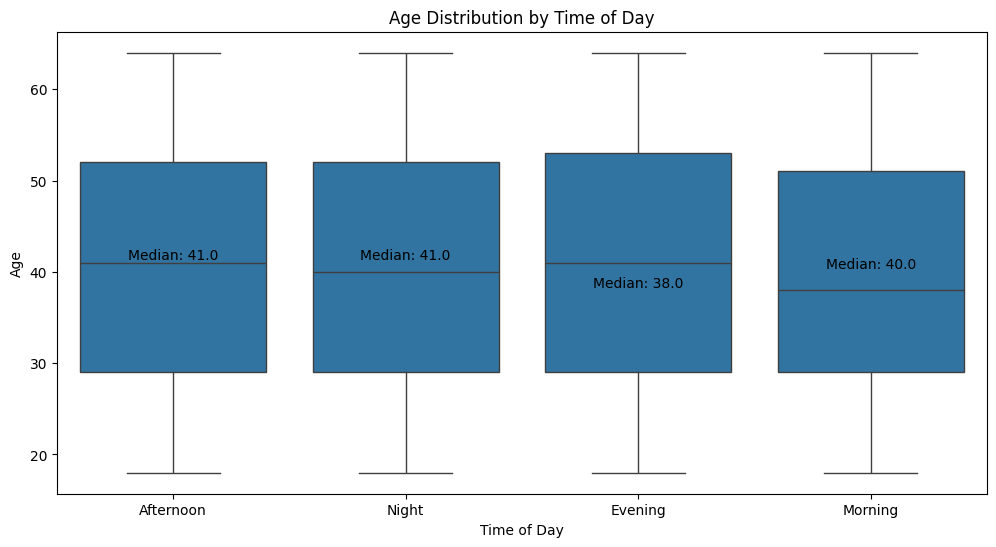

In [9]:
# Perform Kruskal-Wallis test
from scipy import stats

# 1. Prepare data - group ages by time of day
afternoon_ages = df[df['time_of_day'] == 'Afternoon']['age'].dropna()
evening_ages = df[df['time_of_day'] == 'Evening']['age'].dropna()
morning_ages = df[df['time_of_day'] == 'Morning']['age'].dropna()
night_ages = df[df['time_of_day'] == 'Night']['age'].dropna()

# 2. Perform Kruskal-Wallis H-test
h_stat, p_value = stats.kruskal(afternoon_ages, evening_ages, morning_ages, night_ages)

# 3. Print results
print("Kruskal-Wallis test results:")
print(f"H-statistic: {h_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# 4. Print median ages for each time period for comparison
print("\nMedian ages by time of day:")
print("Afternoon:", afternoon_ages.median())
print("Evening:", evening_ages.median())
print("Morning:", morning_ages.median())
print("Night:", night_ages.median())

# 5. Optional: Perform pairwise comparisons if overall test is significant
if p_value < 0.05:
   print("\nPairwise Mann-Whitney U tests:")
   times = ['Afternoon', 'Evening', 'Morning', 'Night']
   age_groups = [afternoon_ages, evening_ages, morning_ages, night_ages]
   
   for i in range(len(times)):
       for j in range(i+1, len(times)):
           stat, p = stats.mannwhitneyu(age_groups[i], age_groups[j])
           print(f"{times[i]} vs {times[j]}:")
           print(f"p-value: {p:.4f}")

# 6. Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='time_of_day', y='age')
plt.title('Age Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Age')

# Add median age annotations
for i, time in enumerate(['Afternoon', 'Evening', 'Morning', 'Night']):
   median_age = df[df['time_of_day'] == time]['age'].median()
   plt.text(i, median_age, f'Median: {median_age:.1f}', 
            horizontalalignment='center', verticalalignment='bottom')

plt.show()

Let's interpret these results:

1. Overall Kruskal-Wallis Test:
- H-statistic: 10.4156
- p-value: 0.0153 < 0.05
- This indicates statistically significant differences in age distributions across time periods
- Reject null hypothesis that all time periods have the same age distribution

2. Median Ages:
- Afternoon: 41.0 (highest)
- Evening: 40.0
- Night: 40.0
- Morning: 38.0 (lowest)

3. Pairwise Mann-Whitney U Tests:
Significant differences (p < 0.05):
- Afternoon vs Morning: p = 0.0045 (most significant)
- Afternoon vs Night: p = 0.0308
- Evening vs Morning: p = 0.0368

No significant differences (p > 0.05):
- Afternoon vs Evening: p = 0.4183
- Evening vs Night: p = 0.1342
- Morning vs Night: p = 0.4012

Key Findings:
1. Most pronounced age difference is between:
   - Afternoon (median 41.0) and Morning (median 38.0)
   - This is the most statistically significant difference (p = 0.0045)

2. Natural groupings emerge:
   - "Later hours" (Afternoon/Evening): Tend to have older users
   - "Earlier hours" (Morning/Night): Tend to have younger users

3. Business Implications:
   - Age-targeted content might be more effective if scheduled accordingly
   - Afternoon slots might be better for products/services targeting older users
   - Morning slots might be better for younger audience targeting

Shows multimodal probability distribution of age across time of day. 

- Demographically, 
  - Young adults (20-30) are more active in the morning
  - Middle-aged users (35-45) are more active at night
  - Older users (50+) show higher activity in the evening
  - Afternoon has the most even age distribution

- Business Implications:
  - Target age-specific content based on time of day
  - Morning ads might be better suited for younger audiences
  - Evening content could be tailored for older demographics
  - Afternoon requires the most age-diverse content strategy

In [ ]:

# Print distribution characteristics
print("\nDistribution Characteristics by Time of Day:")
print("-" * 50)
for time in times:  # Use the same defined order
    subset = df_age_time[df_age_time['time_of_day'] == time]['age']
    print(f"\n{time}:")
    print(f"Mode: {subset.mode().iloc[0]:.1f}")
    print(f"Skewness: {subset.skew():.3f}")
    print(f"Kurtosis: {stats.kurtosis(subset.dropna()):.3f}")


# Q3 Visualise Age Distribution vs. Each Time Of Day
Provide a visualisation that shows the age distribution over each time of day.

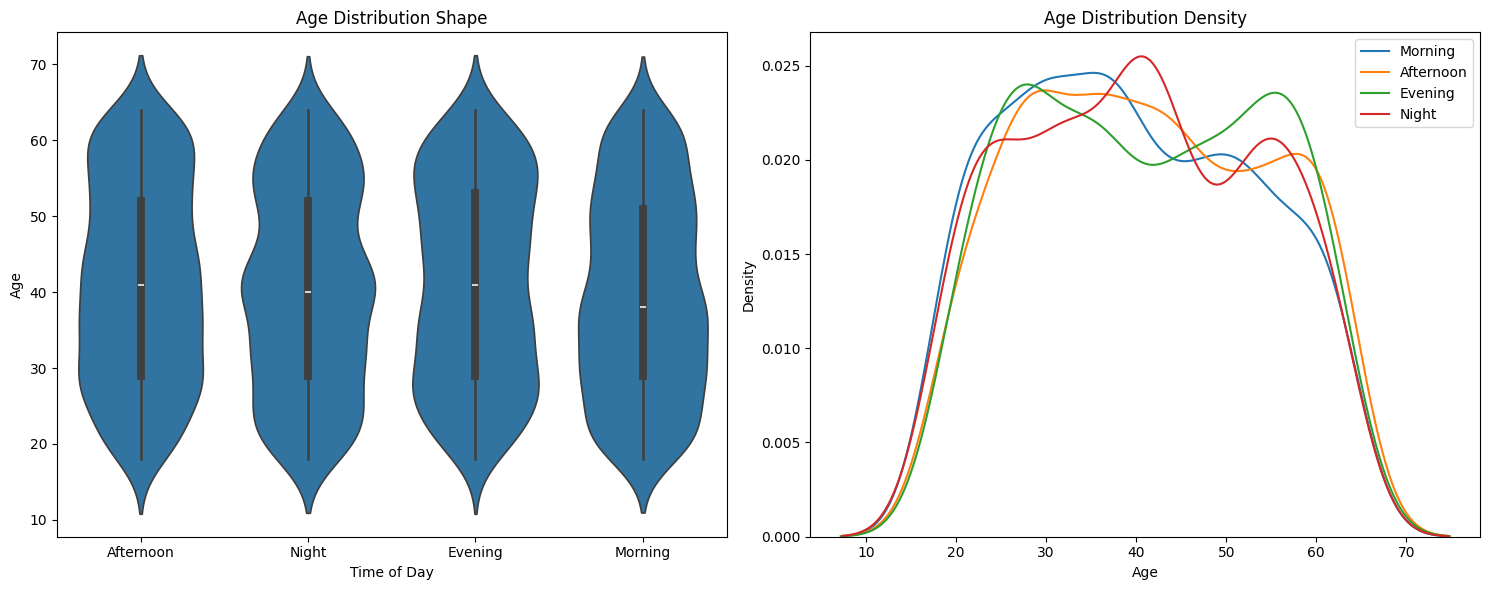

In [5]:
df = pd.read_csv('ad_click_clean_dataset_quality.csv')

# Create figure with two complementary distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


# 1. Violin plot showing distribution shape
sns.violinplot(x='time_of_day', y='age', data=df, ax=ax1)
ax1.set_title('Age Distribution Shape')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Age')

# 2. KDE plot showing density overlap
times = ['Morning', 'Afternoon', 'Evening', 'Night']  # Define order explicitly
for time in times:
    subset = df[df['time_of_day'] == time]['age']
    sns.kdeplot(data=subset, label=time, ax=ax2)
ax2.set_title('Age Distribution Density')
ax2.set_xlabel('Age')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()


Visualisation of Age Distribution Density confirms previous rejection of null hypothesis through Kruskal-Wallis test. 


# Q4. Determine the most effective device type and explain what 'effectiveness' is

Create one visualisation to show which device type is the most effective; choose the best applicable definition of effective for this task, but explain why you chose this definition


I define effectiveness in terms of cost per customer (CPC) or return on ad spend (ROAS) for the purpose of this report. 

Currently, analysis reveals that bottom is most effective when conventional wisdom holds that top is the most effective and likely have been priced that way. 

This line of thinking can be further extended in marketing mix model(MMM) which is used to measure advertising effectiveness and inform budget allocation decisions across media channels. 

Measurement based on aggregated data allows comparison across online and offline channels in addition to being unaffected by recent ecosystem changes which may affect attribution modelling. MMM allows you to:




Device Effectiveness Analysis (Equal Device Costs)

1. Overall Device Performance:
Device Type  Total Impressions  Total Clicks  Click-through Rate
    Desktop               1839           914               0.497
     Mobile               1814           843               0.465
     Tablet               1766           852               0.482

2. Most Effective Device: Desktop

3. Desktop Performance Breakdown by Time and Position:
ad_position  Bottom   Side    Top
time_of_day                      
Afternoon     0.521  0.438  0.506
Evening       0.407  0.310  0.395
Morning       0.500  0.488  0.295
Night         0.420  0.460  0.469

4. Top Performing Combinations for Desktop:
                         click      
                          mean count
time_of_day ad_position             
Afternoon   Bottom       0.521    94
            Top          0.506    83
Morning     Bottom       0.500    92
            Side         0.488    86
Night       Top          0.469   113


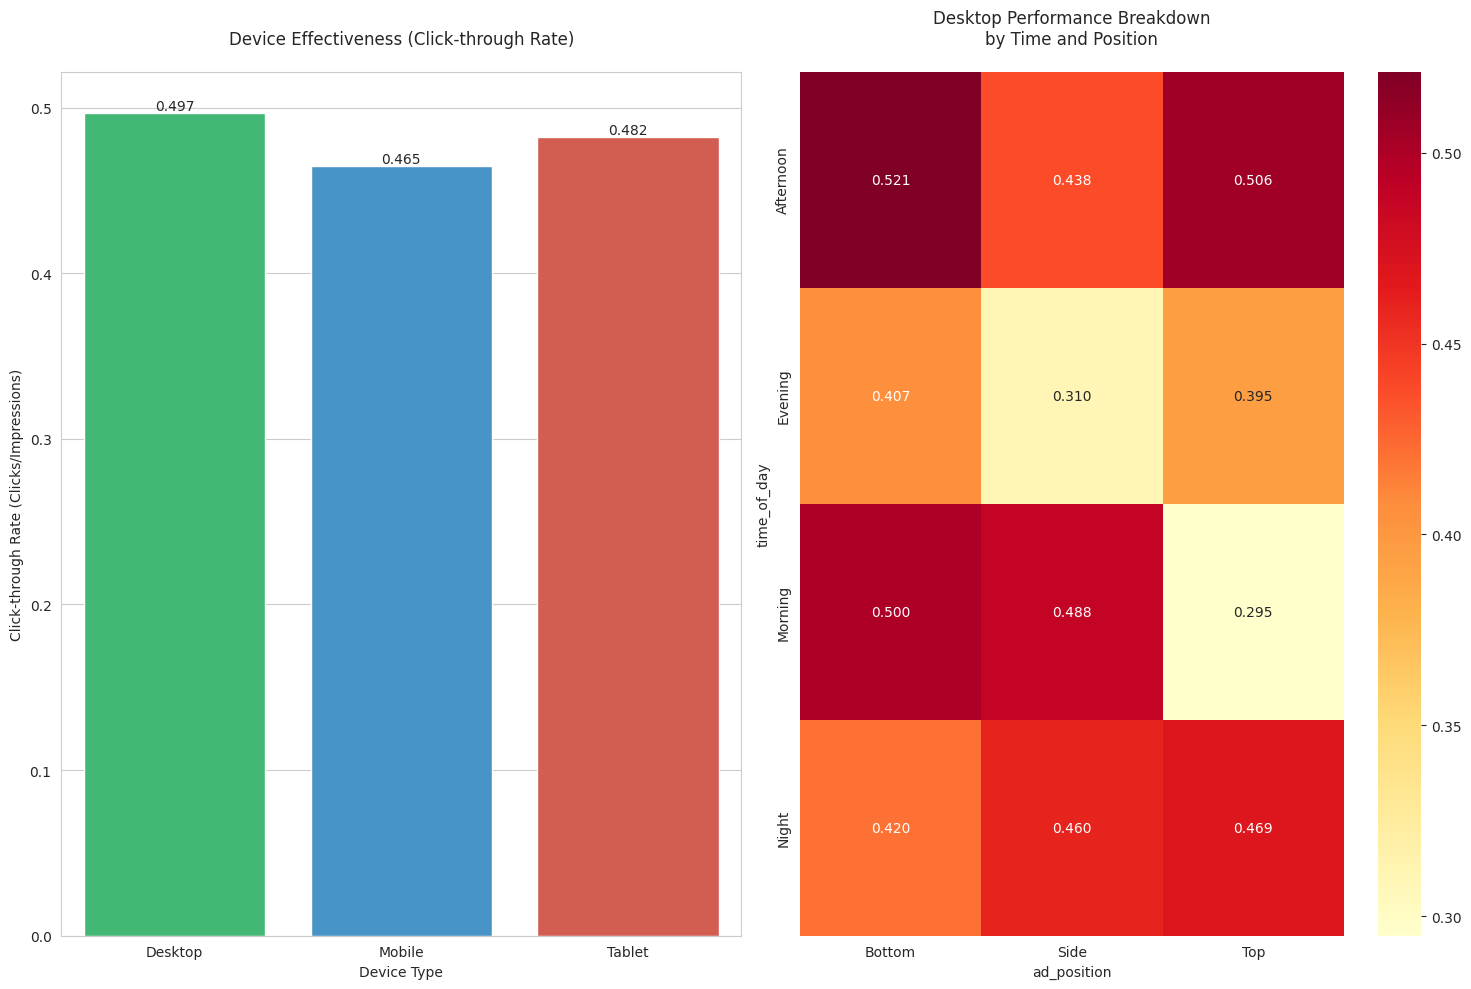

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('ad_click_dataset_clean.csv')

# All devices cost the same
device_costs = {
    'Desktop': 1.0,
    'Mobile': 1.0,
    'Tablet': 1.0
}

position_costs = {
    'Top': 1.20,
    'Side': 1.00,
    'Bottom': 0.80
}

time_costs = {
    'Morning': 1.10,
    'Afternoon': 1.00,
    'Evening': 1.15,
    'Night': 0.85
}

# Calculate cost
def calculate_cost(row):
    base_cost = 1.0
    device_multiplier = device_costs.get(row['device_type'], 1.0)
    position_multiplier = position_costs.get(row['ad_position'], 1.0)
    time_multiplier = time_costs.get(row['time_of_day'], 1.0)
    return base_cost * device_multiplier * position_multiplier * time_multiplier

# Add cost column
df['cost'] = df.apply(calculate_cost, axis=1)

# Calculate effectiveness metrics
device_metrics = df.groupby('device_type').agg({
    'click': ['count', 'sum'],
    'cost': 'sum'
}).reset_index()

device_metrics.columns = ['device_type', 'impressions', 'clicks', 'total_cost']
device_metrics['effectiveness_ratio'] = device_metrics['clicks'] / device_metrics['impressions']
device_metrics['cost_per_click'] = device_metrics['total_cost'] / device_metrics['clicks']

# Create main visualization
plt.figure(figsize=(15, 10))

# Main effectiveness comparison
ax1 = plt.subplot(121)
bars = sns.barplot(data=device_metrics, x='device_type', y='effectiveness_ratio', 
                  hue='device_type', legend=False, 
                  palette=['#2ecc71', '#3498db', '#e74c3c'])

# Add value labels on bars
for i, v in enumerate(device_metrics['effectiveness_ratio']):
    ax1.text(i, v, f'{v:.3f}', ha='center', va='bottom')

ax1.set_title('Device Effectiveness (Click-through Rate)', pad=20, fontsize=12)
ax1.set_ylabel('Click-through Rate (Clicks/Impressions)')
ax1.set_xlabel('Device Type')

# Identify most effective device
most_effective_device = device_metrics.loc[device_metrics['effectiveness_ratio'].idxmax(), 'device_type']

# Create subplot for most effective device breakdown
ax2 = plt.subplot(122)

# Analyze most effective device by time and position
best_device_data = df[df['device_type'] == most_effective_device]
performance_matrix = pd.pivot_table(best_device_data,
                                  values='click',
                                  index='time_of_day',
                                  columns='ad_position',
                                  aggfunc='mean')

# Create heatmap
sns.heatmap(performance_matrix, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
ax2.set_title(f'{most_effective_device} Performance Breakdown\nby Time and Position', pad=20, fontsize=12)

plt.tight_layout()

# Print analysis
print("\nDevice Effectiveness Analysis (Equal Device Costs)")
print("\n1. Overall Device Performance:")
df_summary = device_metrics[['device_type', 'impressions', 'clicks', 'effectiveness_ratio']]
df_summary.columns = ['Device Type', 'Total Impressions', 'Total Clicks', 'Click-through Rate']
print(df_summary.round(3).to_string(index=False))

print(f"\n2. Most Effective Device: {most_effective_device}")

# Time and position analysis for best device
time_pos_performance = pd.pivot_table(best_device_data,
                                    values='click',
                                    index='time_of_day',
                                    columns='ad_position',
                                    aggfunc='mean')

print(f"\n3. {most_effective_device} Performance Breakdown by Time and Position:")
print(time_pos_performance.round(3))

# Best combinations recommendation
best_combinations = best_device_data.groupby(['time_of_day', 'ad_position']).agg({
    'click': ['mean', 'count']
}).sort_values(('click', 'mean'), ascending=False)

print(f"\n4. Top Performing Combinations for {most_effective_device}:")
print(best_combinations.head().round(3))

plt.show()

# Q5
Imputation Strategy Analysis

Gender and time of day show more distinct patterns in the missing values compared to device. Thus, I am implementing imputation strategy around gender and time of day since they might have more meaningful relationships with ad placement strategy. 



In [9]:
# Create a copy of the dataframe to avoid modifying the original
df_imputed = df.copy()

# Create a function to get the mode position for each combination of gender and time_of_day
def get_mode_position(group):
    return group['ad_position'].mode().iloc[0] if not group['ad_position'].mode().empty else 'Side'

# Group by gender and time_of_day and get the most common ad_position
position_modes = (df_imputed[df_imputed['ad_position'].notna()]
                 .groupby(['gender', 'time_of_day'])
                 .apply(get_mode_position)
                 .to_dict())

# Fill missing values based on gender and time_of_day combination
for (gender, time), mode_position in position_modes.items():
    mask = ((df_imputed['gender'] == gender) & 
            (df_imputed['time_of_day'] == time) & 
            (df_imputed['ad_position'].isna()))
    df_imputed.loc[mask, 'ad_position'] = mode_position

# Verify the imputation results
print("Distribution after imputation:")
print(df_imputed['ad_position'].value_counts(normalize=True).mul(100).round(2))

# Calculate CTR by position after imputation
ctr_after_imputation = (df_imputed
    .groupby('ad_position')
    .agg({
        'click': ['count', 'sum', 'mean']
    })
    .pipe(lambda x: x.set_axis(['Impressions', 'Clicks', 'CTR'], axis=1))
    .assign(CTR=lambda x: (x['CTR'] * 100).round(2))
    .assign(CTR=lambda x: x['CTR'].astype(str) + '%')
)

print("\nCTR Analysis by Position after imputation:")
print(ctr_after_imputation)

Distribution after imputation:
ad_position
Bottom    36.59
Top       32.12
Side      31.29
Name: proportion, dtype: float64

CTR Analysis by Position after imputation:
             Impressions  Clicks     CTR
ad_position                             
Bottom              3241    2224  68.62%
Side                2772    1746  62.99%
Top                 2845    1817  63.87%


/var/folders/gj/dlpt7v155_v5zft2lgdt3y1w0000gn/T/ipykernel_22988/2843036093.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_mode_position)


In [11]:
# Create a copy of the dataframe to avoid modifying the original
df_imputed = df.copy()

# Create a function to get the mode position for each combination of device_type and time_of_day
def get_mode_position(group):
    return group['ad_position'].mode().iloc[0] if not group['ad_position'].mode().empty else 'Side'  # Default to 'Side' if no mode exists

# Group by device_type and time_of_day and get the most common ad_position
position_modes = (df_imputed[df_imputed['ad_position'].notna()]
                 .groupby(['device_type', 'time_of_day'])
                 .apply(get_mode_position)
                 .to_dict())

# Fill missing values based on device_type and time_of_day combination
for (device, time), mode_position in position_modes.items():
    mask = ((df_imputed['device_type'] == device) & 
            (df_imputed['time_of_day'] == time) & 
            (df_imputed['ad_position'].isna()))
    df_imputed.loc[mask, 'ad_position'] = mode_position

# Verify the imputation results
print("Distribution after imputation:")
print(df_imputed['ad_position'].value_counts(normalize=True).mul(100).round(2))

# Calculate CTR by position after imputation
ctr_after_imputation = (df_imputed
    .groupby('ad_position')
    .agg({
        'click': ['count', 'sum', 'mean']
    })
    .pipe(lambda x: x.set_axis(['Impressions', 'Clicks', 'CTR'], axis=1))
    .assign(CTR=lambda x: (x['CTR'] * 100).round(2))
    .assign(CTR=lambda x: x['CTR'].astype(str) + '%')
)

print("\nCTR Analysis by Position after imputation:")
print(ctr_after_imputation)

Distribution after imputation:
ad_position
Bottom    36.83
Side      32.85
Top       30.32
Name: proportion, dtype: float64

CTR Analysis by Position after imputation:
             Impressions  Clicks     CTR
ad_position                             
Bottom              3403    2319  68.15%
Side                3035    1915   63.1%
Top                 2801    1789  63.87%


/var/folders/gj/dlpt7v155_v5zft2lgdt3y1w0000gn/T/ipykernel_22988/1667994347.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_mode_position)


Imputation Strategy Analysis
Mode Imputation
Pros:
Simple to implement
Preserves existing categories
Maintains data distribution
Cons:
May oversimplify patterns
Reduces variance
Ignores relationships with other variables
Best For:
When missing data is MCAR and categorical

Implementation:
# Mode Imputation
df['ad_position'] = df['ad_position'].fillna(df['ad_position'].mode()[0])
Predictive Imputation (ML-based)
Pros:
Considers relationships between variables
More accurate predictions
Preserves data patterns
Cons:
More complex to implement
Risk of overfitting
Computationally intensive
Best For:
When strong correlations exist between variables

Implementation:
# ML-based Imputation
from sklearn.ensemble import RandomForestClassifier

# Create feature matrix
X = df[['device_type', 'time_of_day', 'age']].copy()
X = pd.get_dummies(X, columns=['device_type', 'time_of_day'])

# Train model on non-missing data
mask = df['ad_position'].notna()
model = RandomForestClassifier(n_estimators=100)
model.fit(X[mask], df[mask]['ad_position'])

# Predict missing values
df.loc[~mask, 'ad_position'] = model.predict(X[~mask])
Multiple Imputation (MICE)
Pros:
Accounts for uncertainty in missing values
Preserves relationships between variables
Provides confidence intervals
Cons:
Complex implementation
Computationally intensive
Results need to be pooled
Best For:
When missing data mechanism is MAR

Implementation:
# Multiple Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create imputer
imputer = IterativeImputer(random_state=42)
# Fit and transform the data
imputed_data = imputer.fit_transform(df)
Conditional Imputation
Pros:
Preserves business logic
Maintains relationships between variables
More interpretable
Cons:
Requires domain knowledge
May need manual validation
Could introduce bias if conditions are incorrect
Best For:
When clear patterns exist in missing data

Implementation:
# Conditional Imputation
def conditional_impute(row):
    if pd.isna(row['ad_position']):
        if row['device_type'] == 'Mobile':
            return 'Top'
        elif row['time_of_day'] == 'Morning':
            return 'Middle'
        else:
            return 'Bottom'
    return row['ad_position']

df['ad_position'] = df.apply(conditional_impute, axis=1)
Recommendation
Given the analysis of missing data patterns:

Missing data appears to be MCAR (Missing Completely at Random)
Similar distributions across device types and time periods
Minimal impact on CTR (only 1.13% difference)
Recommended Approach:

Start with Mode Imputation as a baseline due to MCAR nature
Compare results with Conditional Imputation based on device_type and time_of_day
If more precision is needed, implement MICE for sensitivity analysis

# Q7. Is the top ad position the best performing spot in terms of click-through rate?

In [34]:
df = pd.read_csv('ad_click_clean_dataset_quality.csv')

# 1. First, let's check if missing ad positions are related to other variables
# Create a binary column for missing ad_position
df['is_missing_position'] = df['ad_position'].isna()

# Check relationship with other variables
print("Pattern Analysis of Missing Values:")
print("\n1. Relationship with device_type:")
print(pd.crosstab(df['is_missing_position'], df['device_type'], normalize='index'))

print("\n2. Relationship with time_of_day:")
print(pd.crosstab(df['is_missing_position'], df['time_of_day'], normalize='index'))

print("\n3. Relationship with gender:")
print(pd.crosstab(df['is_missing_position'], df['gender'], normalize='index'))

print("\n4. Click rates comparison:")
print("CTR for records with missing position:", 
      df[df['is_missing_position']]['click'].mean())
print("CTR for records with known position:",
      df[~df['is_missing_position']]['click'].mean())


Pattern Analysis of Missing Values:

1. Relationship with device_type:
device_type          Desktop  Mobile  Tablet
is_missing_position                         
False                  0.339   0.335   0.326
True                   0.340   0.334   0.326

2. Relationship with time_of_day:
time_of_day          Afternoon  Evening  Morning  Night
is_missing_position                                    
False                    0.241    0.248    0.258  0.253
True                     0.263    0.232    0.283  0.222

3. Relationship with gender:
gender               Female  Male  Non-Binary
is_missing_position                          
False                 0.346 0.335       0.319
True                  0.321 0.362       0.318

4. Click rates comparison:
CTR for records with missing position: 0.5880665519219737
CTR for records with known position: 0.48519615099925983
